# VIC - Introduction to Visual Computing

**Instructor:** Maria Vakalopoulou\
**T.A.:** Joseph Boyd\
**Date:** December 16, 2022

## Image segmentation

For the lab exercises use `jupyter` or `colab` (or anything else at your own risk). It can be installed by issuing `pip install jupyter` on Linux after installing pip itself with `apt install python-pip`. Mac and Windows users can find the installation instructions online. The first thing that is needed is to import some libraries, such as `numpy`, `scipy`, `random` and `matplotlib` for visualization. If they are missing you can simply install them with e.g., `pip install numpy`

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Otsu's method

Otsu's method performs a binary segmentation of the image into two classes (foregound and background) by choosing an intensity threshold $T \in \{0, \ldots, L-1\}$ for the $L$ image greylevels, so as to maximise the inter-class variance,

$$T = \arg\max_{t} w_0(t)\cdot w_1(t)\cdot [\mu_0(t) - \mu_1(t)]^2,$$

where the $w_0(t)$ and $w_1(t)$ are the class probabilities for a given choice of $t$,

$$w_0(t) = \sum_{i=0}^{t-1}p(i)$$

$$w_1(t) = \sum_{i=t}^{L-1}p(i),$$

and the class means,

$$\mu_0(t) = \frac{\sum_{i=0}^{t-1}ip(i)}{w_0(t)}$$

$$\mu_1(t) = \frac{\sum_{i=t}^{L-1}ip(i)}{w_1(t)}$$

First let's load an image into memory:

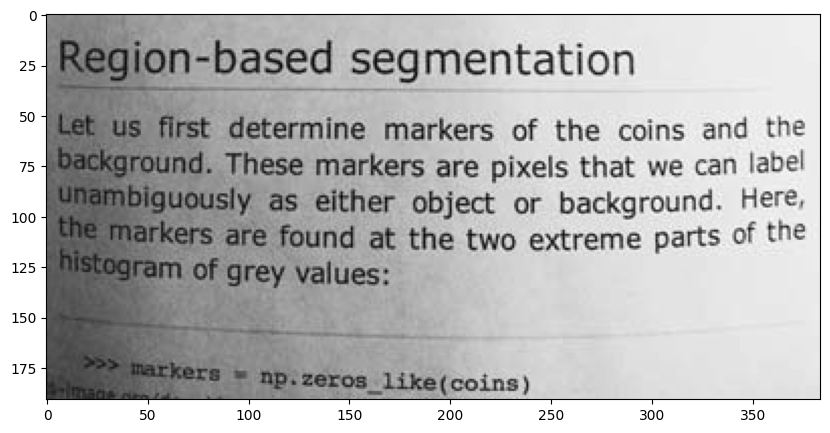

In [2]:
from skimage.data import page

img = page()

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img, cmap='gray')

First, compute the histogram of image intensity values using `numpy.bincount` and plot using `matplotlib.pyplot.plot`:

Text(0, 0.5, 'Bin count')

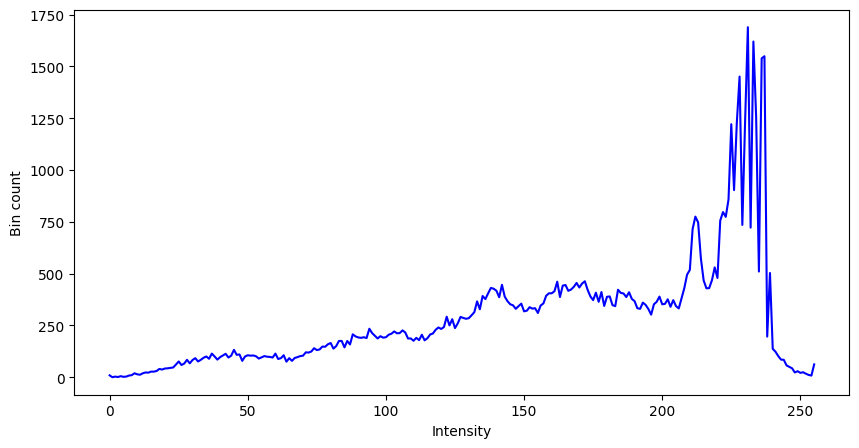

In [3]:
hist = np.bincount(img.flatten())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist, color='blue')
ax.set_xlabel('Intensity')
ax.set_ylabel('Bin count')

Compute the vector of class probabilities $w_0(t)$ and $w_1(t)$ for all $t$:

In [4]:
w_0 = np.cumsum(hist) / np.sum(hist)
w_1 = 1 - w_0

Compute the vector of class means $\mu_0(t)$ and $\mu_1(t)$ for all $t$:

In [5]:
num_val = len(hist)
probs = hist / np.sum(hist)
weighted_sums = np.cumsum(np.arange(num_val) * probs)

mu_0 = weighted_sums / w_0
mu_1 = (weighted_sums[-1] - weighted_sums) / w_1

/tmp/ipykernel_57282/1095867551.py:6: RuntimeWarning: invalid value encountered in divide
  mu_1 = (weighted_sums[-1] - weighted_sums) / w_1


Now iterate over all intensity values to find the optimal threshold `T`:

In [6]:
max_var = -float('inf')
T = None

for t in range(num_val - 1):

    var = w_0[t] * w_1[t] * (mu_0[t] - mu_1[t]) ** 2

    if var > max_var:
        max_var = var
        T = t

print(f'Otsu threshold: {T}')

Otsu threshold: 157


In [7]:
from ipywidgets import interact, widgets
from IPython.display import display

hist = np.bincount(img.flatten())
masks = [img > threshold for threshold in range(255)]

def f_display(threshold):
    fig, axes = plt.subplots(figsize=(15, 3), ncols=2)
    axes[0].imshow(masks[threshold], cmap='gray')
    axes[1].plot(hist, color='blue')
    axes[1].axvline(threshold, color='red', linestyle='--')

interact(f_display, threshold=widgets.IntSlider(min=0, max=255, step=1, value=T));

interactive(children=(IntSlider(value=157, description='threshold', max=255), Output()), _dom_classes=('widget…

# Watershed algorithm

The watershed algorithm can be used for separating objects in an image. From a set of initial markers, it simulates a "flooding" of the image topology by growing outwards from the markers until regions intersect. The resulting boundaries between regions are known as *watershed lines*.

We will apply the watershed algorithm as part of a segmentation pipeline for separating cells in a fluorescence microscopy image taken from the [2018 Data Science Bowl](https://bbbc.broadinstitute.org/BBBC038) dataset.

First, let's load the image and perform a Gaussian blur for denoising:

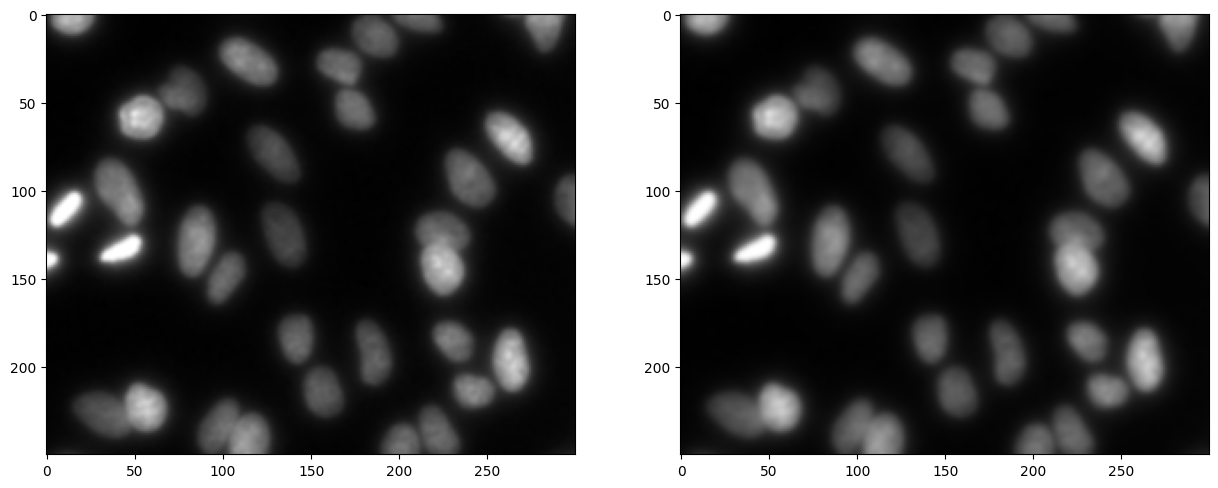

In [8]:
from skimage.io import imread
from skimage.filters import gaussian

img = imread('cells.png')

fig, axes = plt.subplots(figsize=(15, 10), ncols=2)
axes[0].imshow(img, cmap='gray')

filtered_img = gaussian(img, sigma=1)

axes[1].imshow(filtered_img, cmap='gray')

Now, apply a threshold using Otsu's method. You may use the `skimage` library function, or your own from above.

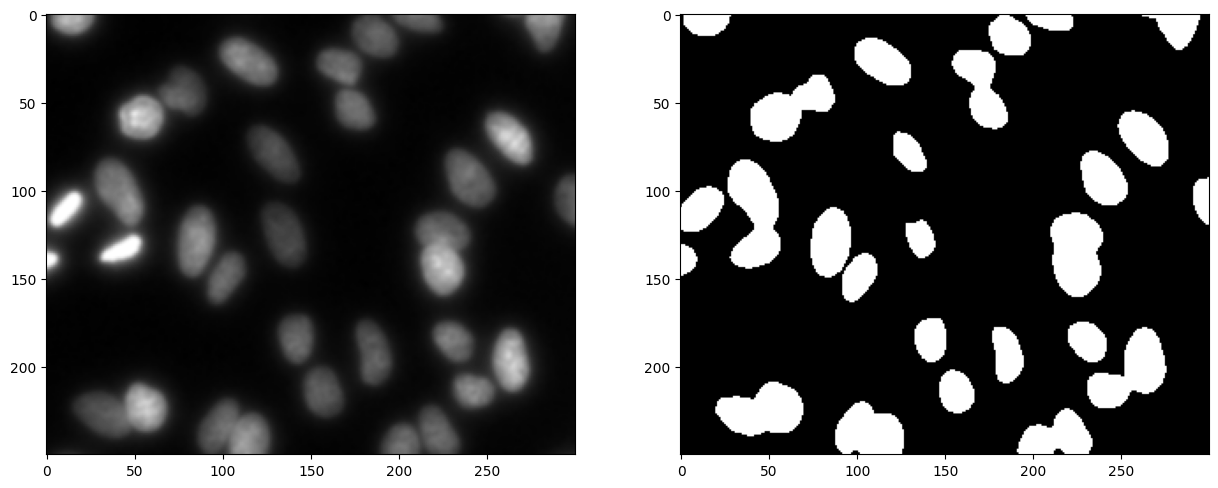

In [9]:
from skimage.filters import threshold_otsu

T = threshold_otsu(filtered_img)

segmentation = filtered_img > T

fig, axes = plt.subplots(figsize=(15, 10), ncols=2)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(segmentation, cmap='gray')

The main challenge for the watershed algorithm is automatically selecting the flooding markers. A common approach is to select the local maxima of the image distance map. For a given binary segmentation, the distance map is an image indicating the shortest distance (whether Euclidean or other) of each foreground pixel to the background. Use `scipy.ndimage.distance_transform_edt` for compute the distance map for the above segmentation:

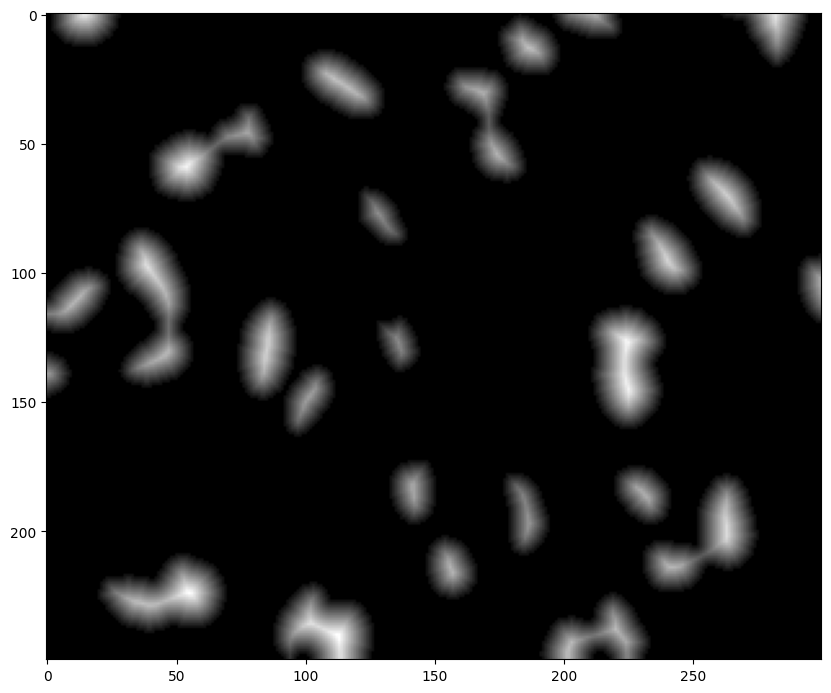

In [10]:
from scipy.ndimage import distance_transform_edt

distance_map = distance_transform_edt(segmentation)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(distance_map, cmap='gray')

Use the `skimage.feature.peak_local_max` to compute maxima for `distance_map`. You will need to adjust the `min_distance` and `footprint` parameters to find a balance between over- and under-segmentation. **N.B** the aim is have one marker per cell. Then, create a `local_maxima` that is non-zero only at the marker points. Finally, we use `skimage.measure.label` to attribute a unique value for each label, which we then visualise.

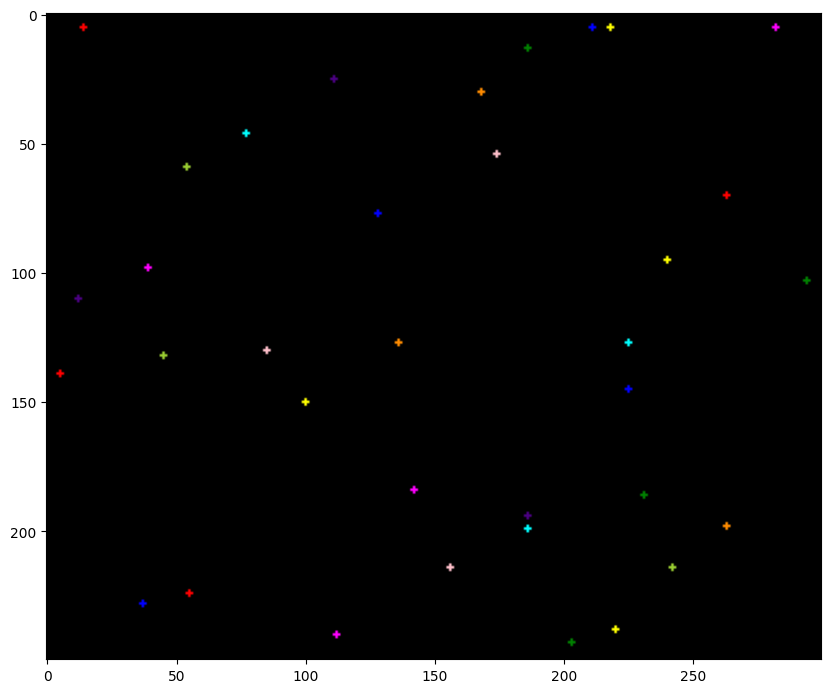

In [11]:
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.color import label2rgb

max_coords = peak_local_max(distance_map, labels=segmentation, min_distance=5,
                            footprint=np.ones((15, 15)))

local_maxima = np.zeros_like(img, dtype=bool)
local_maxima[tuple(max_coords.T)] = True

markers = label(local_maxima)

from skimage.morphology import disk, dilation
selem = disk(1)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(label2rgb(dilation(markers, selem), bg_label=0))

Apply the function `skimage.segmentation.watershed` to `distance_map` using the `markers` compute above, as well as at the binary `segmentation` as the `mask` parameter. Set `watershed_line=True` for a cleaner visualisation. **N.B.** By convention, the watershed "floods" from bottom-to-top. Therefore, the *inverse* (negative) distance map is used.

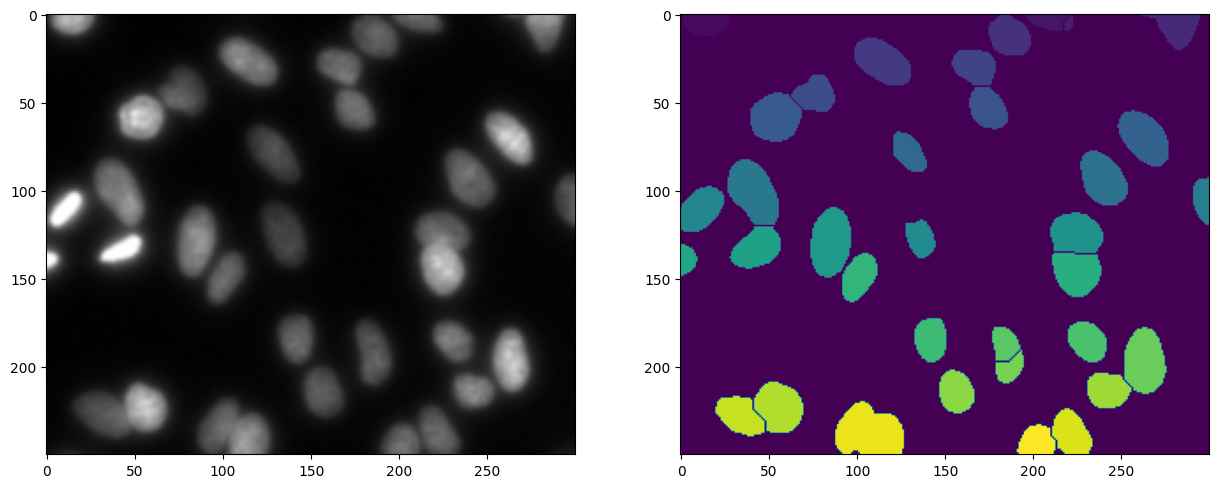

In [12]:
from skimage.segmentation import watershed

labels = watershed(-distance_map, markers, mask=segmentation, watershed_line=True)

fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

axes[0].imshow(img, cmap='gray')
axes[1].imshow(labels)

## SLIC

Simple linear iterative clustering (SLIC) is an algorithm for computing *superpixels*, an intermediary between pixels and objects. Superpixels are groups of pixels that cluster both by proximity and by colour properties.

Let's begin by loading an image:

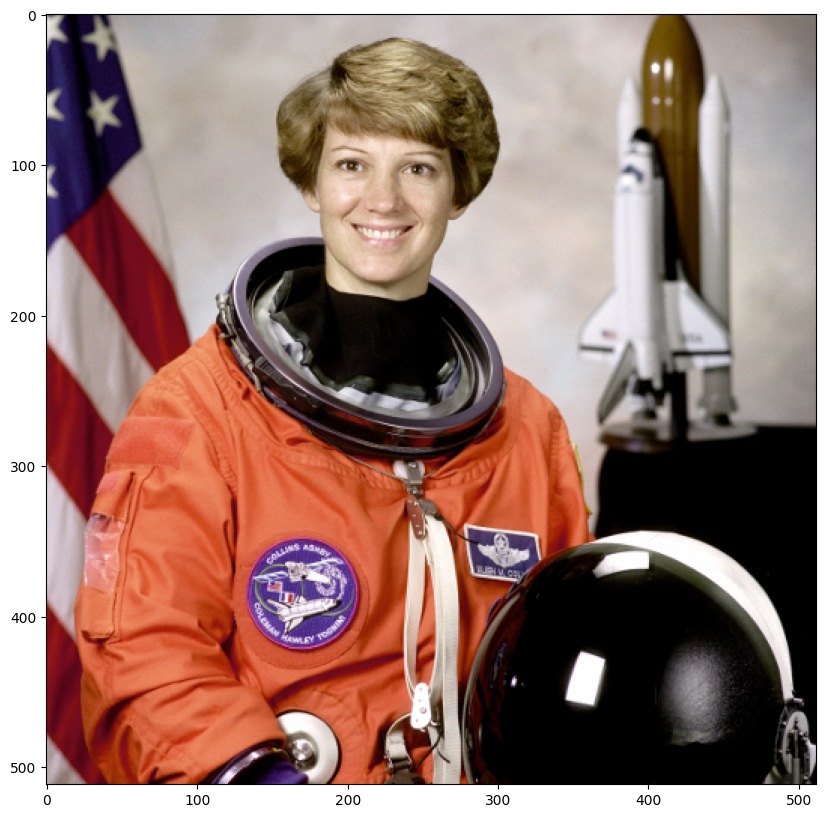

In [16]:
from skimage import data

img = data.astronaut()

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)

Use `skimage.segmentation.slic` to compute superpixels for the above image. You should tune the parameters `n_segments`, the number of superpixels, and `compactness`, the greater the compactness, the more spatial the clustering.

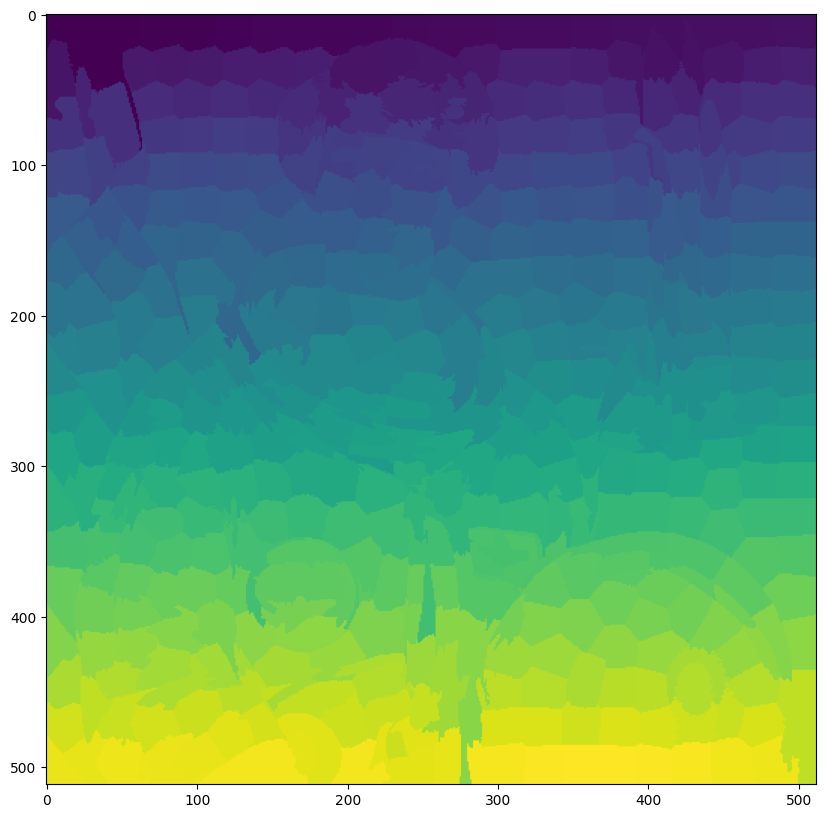

In [17]:
from skimage.segmentation import slic

segments = slic(img, n_segments=500, compactness=20)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(segments)

Run the code below to visualise the superpixel contours:

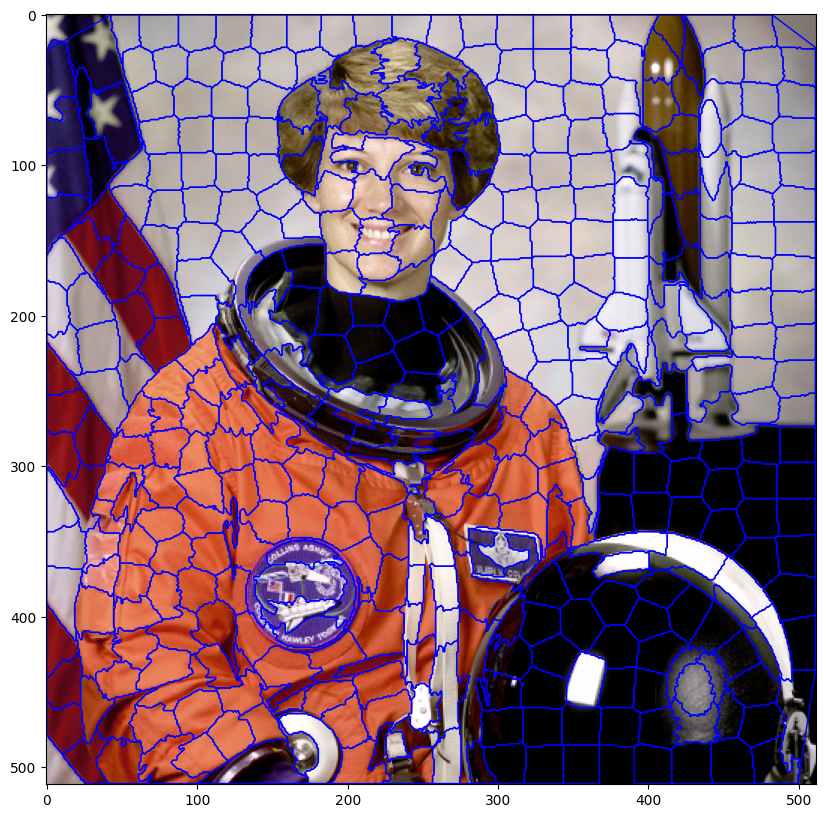

In [23]:
from skimage.measure import find_contours

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

for i in range(np.max(segments)):
    cont = find_contours(segments == i)
    if len(cont) == 0:
        continue
    cont = cont[0]
    ax.fill(cont[:, 1], cont[:, 0], facecolor='none', edgecolor='blue')

Now let's try and code SLIC from scratch! SLIC represents each pixel $p_k$ as a 5-dimensional vector,

$$p_i = [l_i, a_i, b_i, x_i, y_i],$$

where $l_i, a_i, b_i$ are the values from the CIELAB transformation of the RGB colour space, and $x_i, y_i$ are the spatial coordinates of $p_i$.

First, compute these features for each pixel in a $512 \times 512 \times 5$ `numpy.array`:

In [24]:
from skimage.color import rgb2rgbcie

img_cie = rgb2rgbcie(img)

H, W = img.shape[:2]

xx, yy = np.meshgrid(np.arange(H), np.arange(W))

features = np.dstack([img_cie, xx, yy])

print(features.shape)

(512, 512, 5)


SLIC iteratively updates cluster centers, the centroids of the superpixels. Initially, these are allocated according to a regular grid, controlled by a spatial paramters $S$.

In [25]:
S = 25

center_x = np.linspace(S, W - S, num=W // S).astype('int')
center_y = np.linspace(S, H - S, num=H // S).astype('int')

xx, yy = np.meshgrid(center_x, center_y)
center_coords = np.dstack([xx.flatten(), yy.flatten()])[0]

**Optional**: Compute the gradient,

$$G(x, y) = ||I(x + 1, y) - I(x - 1, y)||^2 + ||I(x, y + 1) - I(x, y - 1)||^2,$$

and "perturb" the initial superpixel centroids by shifting them to the pixel of lowest gradient in a $3\times3$ surrounding window.

In [26]:
# first pad image to maintain image size
padded_cie = np.pad(img_cie, pad_width=[(1, 1), (1, 1), (0, 0)], mode='edge')

G_x = padded_cie[1:-1, 2:] - padded_cie[1:-1, :-2]
G_y = padded_cie[2:, 1:-1] - padded_cie[:-2, 1:-1]

G_xy = np.sum(G_x ** 2, axis=2) + np.sum(G_y ** 2, axis=2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(G_xy, cmap='gray')

In [27]:
for i, (x, y) in enumerate(center_coords):
    neigh = G_xy[y - 1 : y + 2, x - 1 : x + 2]
    # find minimising offset
    dy, dx = np.array(np.unravel_index(neigh.argmin(), neigh.shape)) - 1
    center_coords[i] = [x + dx, y + dy]

centers = np.array([features[y, x] for x, y in center_coords])

For each cluster, one examines all pixels $p_i$ in a $2S \times 2S$ window around the cluster $k$ centroid, $p_k = [l_k, a_k, b_k, x_k, y_k]$. Pixels are assigned the cluster minimising the distance,

$$D_s = d_{lab} + \frac{m}{S}d_{xy},$$

where $d_{lab} = \sqrt{(l_k - l_i)^2 + (a_k - a_i)^2 + (b_k - b_i)^2}$, and $d_{xy} = \sqrt{(x_k - x_i)^2 + (y_k - y_i)^2}$. Once all pixels have been assigned, new cluster centroids are computed as the element-wise mean of all member pixels. The algorithm iterates until centroid locations are unchanged within a certain tolerance under an $L_1$ error.

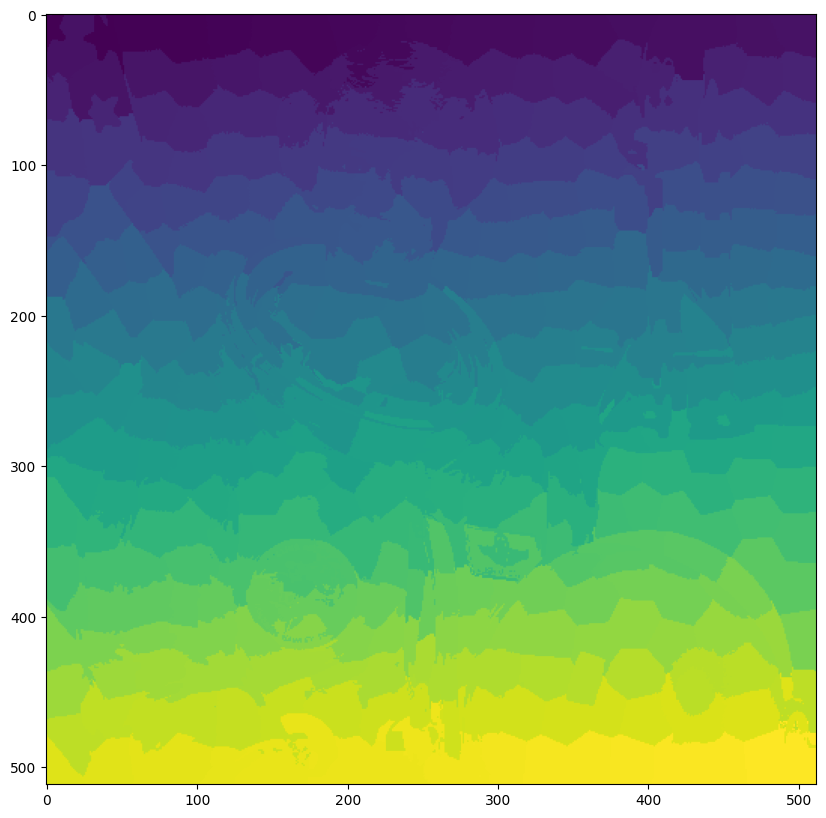

In [28]:
m = 0.1 # compactness - note our features are unnormalised, so we are outside the typical range [1, 20]

E = float('inf')
tol = 5e-2

while E > tol:

    superpixels = np.zeros((H, W))
    distances = float('inf') * np.ones((H, W))

    for center_idx, center_feature in enumerate(centers):

        # form superpixel window
        x, y = int(center_feature[3]), int(center_feature[4])

        t, b = max(y - S, 0), min(y + S, H)
        l, r = max(x - S, 0), min(x + S, W)

        window = features[t:b, l:r]
        
        # compute distances
        d_lab = np.sqrt(np.sum((window[..., :3] - center_feature[:3]) ** 2, axis=2))
        d_xy = np.sqrt(np.sum((window[..., 3:] - center_feature[3:]) ** 2, axis=2))

        D_s = d_lab + (m / S) * d_xy

        # reassign classes if shorter distance found
        classes = superpixels[t:b, l:r]
        classes[distances[t:b, l:r] > D_s] = center_idx
        superpixels[t:b, l:r] = classes

        # update distances
        distances[t:b, l:r] = np.minimum(distances[t:b, l:r], D_s)

    # Update superpixel centers
    new_centers = np.zeros_like(centers)

    for center_idx in range(len(centers)):
        superpixel = superpixels == center_idx
        new_centers[center_idx] = np.mean(features[superpixel], axis=0)

    # Compute L1 error
    E = np.mean(np.abs(new_centers - centers))
    centers = new_centers

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(superpixels)

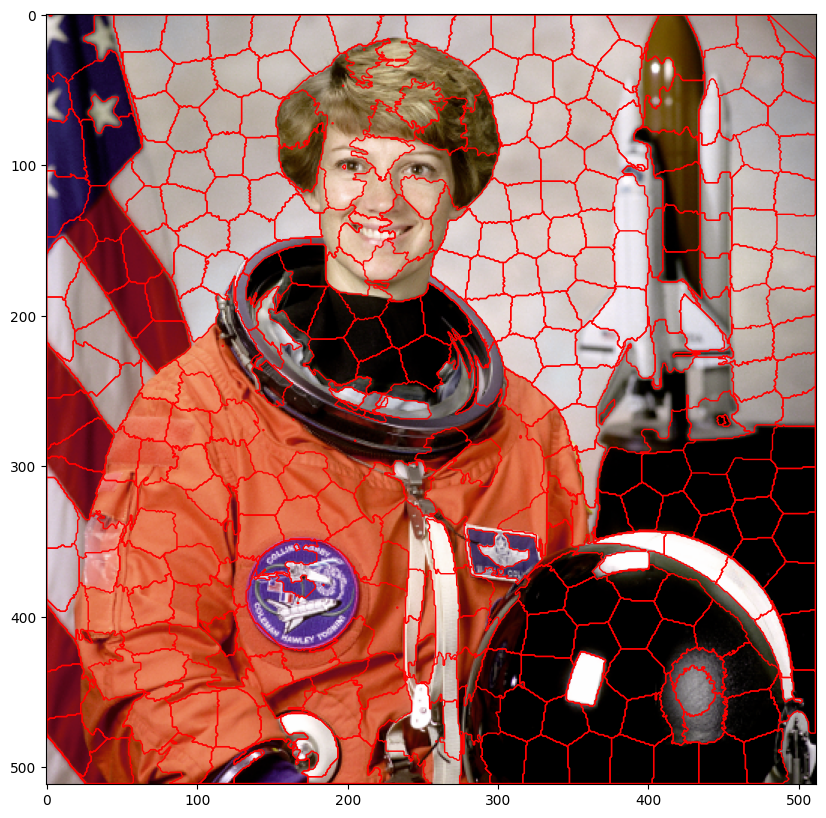

In [29]:
segments = superpixels.astype('int')

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

for i in range(np.max(segments)):
    cont = find_contours(segments == i)[0]
    ax.fill(cont[:, 1], cont[:, 0], facecolor='none', edgecolor='red')

The final part of the algorithm is to enforce connectivity (remove small, disjoint regions). This is left as an extension exercise.